In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing import image_dataset_from_directory
%matplotlib inline 

In [3]:
input_shape = (299, 299, 3)
batch = 8
epochs = 50
lr = 0.001

In [4]:
img_gen = ImageDataGenerator(rescale=1/255)

In [5]:
train_gen = img_gen.flow_from_directory('dataset/train',
                                       target_size=input_shape[:2],
                                       batch_size=batch,
                                       class_mode='categorical',
                                       shuffle=True,
                                       seed=42)

val_gen = img_gen.flow_from_directory('dataset/validation',
                                        target_size=input_shape[:2],
                                        batch_size=batch,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=42)

Found 11540 images belonging to 3 classes.
Found 3553 images belonging to 3 classes.


222.0625

In [57]:
test_gen.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

The main idea is to use pretrained model ResNet50 and then train it on the data that we provide.

In [95]:
# using pretrained model 
baseModel = Xception(weights='imagenet', input_shape=input_shape ,include_top=False)

# next step is to construct top of model to feed data
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# actual model that we`ll be used
model = Model(inputs=baseModel.input, outputs=headModel)

# turn off the tuning of the base parametrs
for layer in baseModel.layers:
    layer.trainable = False
    
opt = Adam(lr=lr)
model.compile(loss="categorical_crossentropy", optimizer=opt,
             metrics=["accuracy"])

In [96]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [97]:
res = model.fit_generator(train_gen, 
                         steps_per_epoch=len(train_gen)//batch,
                         epochs=epochs,
                         validation_data=val_gen,
                         validation_steps=len(val_gen)//batch,
                         use_multiprocessing=True)

Epoch 1/50
180/180 [==============================] - 523s 3s/step - loss: 2.2870 - acc: 0.7229 - val_loss: 0.5524 - val_acc: 0.7841
Epoch 2/50
180/180 [==============================] - 518s 3s/step - loss: 0.5979 - acc: 0.7868 - val_loss: 0.5443 - val_acc: 0.7568
Epoch 3/50
180/180 [==============================] - 516s 3s/step - loss: 0.5468 - acc: 0.7917 - val_loss: 0.6012 - val_acc: 0.7682
Epoch 4/50
180/180 [==============================] - 515s 3s/step - loss: 0.4954 - acc: 0.8245 - val_loss: 0.4893 - val_acc: 0.8068
Epoch 5/50
180/180 [==============================] - 517s 3s/step - loss: 0.5549 - acc: 0.8056 - val_loss: 0.5098 - val_acc: 0.8205
Epoch 6/50
180/180 [==============================] - 515s 3s/step - loss: 0.4659 - acc: 0.8278 - val_loss: 0.6416 - val_acc: 0.7295
Epoch 7/50
180/180 [==============================] - 522s 3s/step - loss: 0.5145 - acc: 0.8167 - val_loss: 0.5777 - val_acc: 0.7273
Epoch 8/50
180/180 [==============================] - 525s 3s/step - 

In [102]:
model.save('best_head.h5')

AttributeError: 'History' object has no attribute 'save'

In [105]:
def plot_model(N = epochs, H=res):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    plt.show()

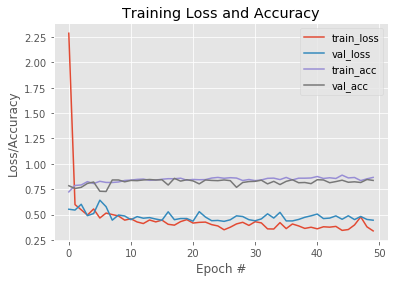

In [106]:
plot_model()